# Import libraries

In [1]:
import numpy as np
import pandas as pd 
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from keras.layers import TimeDistributed,LSTM, Embedding, Dense, Dropout, AdditiveAttention, Input, Concatenate
from sklearn.metrics import accuracy_score
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K

2025-10-12 01:53:46.262219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760234026.471567      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760234026.527528      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load data

In [2]:
from datasets import load_dataset

dataset = load_dataset("KhoaUIT/VNDS-Vietnews")

README.md:   0%|          | 0.00/526 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

data/valid-00000-of-00001.parquet:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/105418 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/22642 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22644 [00:00<?, ? examples/s]

In [3]:
train_data = dataset['train'].select(range(50000))
train_df = train_data.to_pandas()
valid_data = dataset['valid'].select(range(11000))
valid_df = valid_data.to_pandas()
test_data = dataset['test'].select(range(11000))
test_df = test_data.to_pandas()

In [4]:
print("train_df shape: ",train_df.shape)
print("valid_df shape: ",valid_df.shape)
print("test_df shape: ",test_df.shape)

train_df shape:  (50000, 2)
valid_df shape:  (11000, 2)
test_df shape:  (11000, 2)


# Preprocessing

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  50000 non-null  object
 1   Summary  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
# Loại bỏ các hàng trùng
train_df = train_df.drop_duplicates()
valid_df = valid_df.drop_duplicates()
test_df = test_df.drop_duplicates()

In [7]:
print("train_df shape: ",train_df.shape)
print("valid_df shape: ",valid_df.shape)
print("test_df shape: ",test_df.shape)

train_df shape:  (49194, 2)
valid_df shape:  (10968, 2)
test_df shape:  (10971, 2)


In [8]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub('', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [9]:
train_df['Content'] = train_df['Content'].apply(clean_text)
train_df['Summary'] = train_df['Summary'].apply(clean_text)
valid_df['Content'] = valid_df['Content'].apply(clean_text)
valid_df['Summary'] = valid_df['Summary'].apply(clean_text)
test_df['Content'] = test_df['Content'].apply(clean_text)
test_df['Summary'] = test_df['Summary'].apply(clean_text)

In [10]:
print(train_df['Content'][:5])

0    ngày 213 ban chấp hành bch đoàn thanh niên cơ ...
1    mới đây cơ quan csđt công an tỉnh hoà bình vừa...
2    cười xuyên việt là một trong những chương trìn...
3    thách thức danh hài mùa 3 kết thúc với chiến t...
4    truyền thông nhật cho biết tại cuộc họp báo hô...
Name: Content, dtype: object


In [11]:
if "<start>" not in train_df['Summary'][0]:
    train_df['Summary'] = ['<start> ' + sentence + ' <end>' for sentence in train_df['Summary']]
    valid_df['Summary'] = ['<start> ' + sentence + ' <end>' for sentence in valid_df['Summary']]
    test_df['Summary'] = ['<start> ' + sentence + ' <end>' for sentence in test_df['Summary']]

In [12]:
train_df['Summary']

0        <start> với tinh thần “ một giọt máu trao đi m...
1        <start> luật sư bào chữa cho bác sĩ hoàng công...
2        <start> danh hài việt hương sẽ giữ vai trò giá...
3        <start> giữa “ bão ” bị chỉ trích vì cười dễ d...
4        <start> thứ trưởng bộ tài chính nhật junichi f...
                               ...                        
49994    <start> bộ trưởng kinh tế triều tiên kêu gọi m...
49995    <start> số người tử vong trong cuộc bầu cử ind...
49996    <start> trước áp lực quá tải trường lớp một tr...
49997    <start> công an tp vinh nghệ an cho hay việc c...
49999    <start> lực lượng chức năng thành phố sẽ giải ...
Name: Summary, Length: 49194, dtype: object

# Tokenizer

In [13]:
tok = Tokenizer(num_words=60000, oov_token="<OOV>")
tok.fit_on_texts(train_df['Content'] + train_df['Summary'])

In [14]:
total_words = len(tok.word_index) + 1
print('Total words: ', total_words)

Total words:  63467


In [15]:
# Convert contents and summaries to sequences
train_df['Content'] = tok.texts_to_sequences(train_df['Content'])
train_df['Summary'] = tok.texts_to_sequences(train_df['Summary'])

test_df['Content'] = tok.texts_to_sequences(test_df['Content'])
test_df['Summary'] = tok.texts_to_sequences(test_df['Summary'])

valid_df['Content'] = tok.texts_to_sequences(valid_df['Content'])
valid_df['Summary'] = tok.texts_to_sequences(valid_df['Summary'])

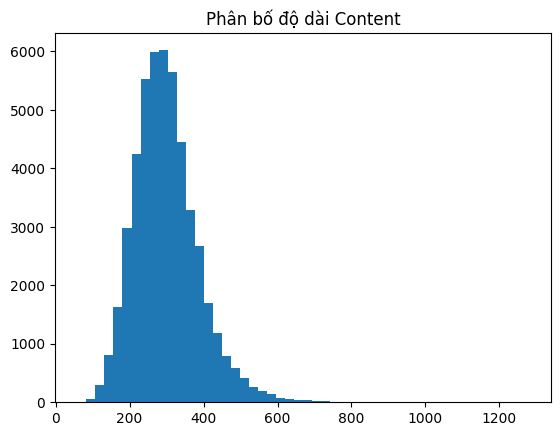

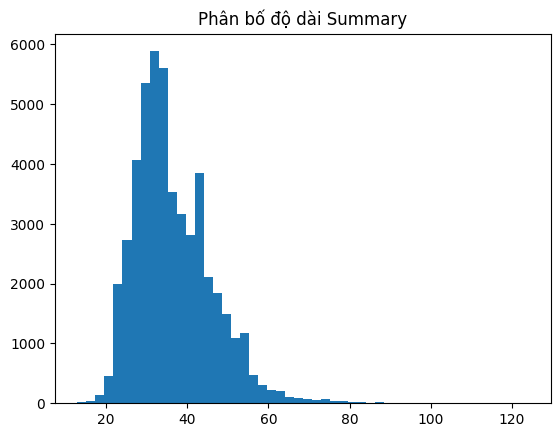

Trung bình Content: 299.75564093182095
95 percentile Content: 455.0
Max Content: 1278


In [16]:
import numpy as np
import matplotlib.pyplot as plt

content_lens = [len(x) for x in train_df['Content']]
summary_lens = [len(x) for x in train_df['Summary']]

plt.hist(content_lens, bins=50)
plt.title("Phân bố độ dài Content")
plt.show()

plt.hist(summary_lens, bins=50)
plt.title("Phân bố độ dài Summary")
plt.show()

print("Trung bình Content:", np.mean(content_lens))
print("95 percentile Content:", np.percentile(content_lens, 95))
print("Max Content:", np.max(content_lens))

In [17]:
max_length_content = int(np.percentile(content_lens, 95))
max_length_summary = int(np.percentile(summary_lens, 95))

print("Giới hạn đề xuất:")
print("max_length_input =", max_length_content)
print("max_length_output =", max_length_summary)

Giới hạn đề xuất:
max_length_input = 455
max_length_output = 54


In [18]:
X_train = pad_sequences(train_df['Content'],maxlen = max_length_content,padding = 'post')
y_train = pad_sequences(train_df['Summary'],maxlen = max_length_summary,padding = 'post')
X_valid = pad_sequences(valid_df['Content'],maxlen = max_length_content,padding = 'post')
y_valid = pad_sequences(valid_df['Summary'],maxlen = max_length_summary,padding = 'post')
X_test = pad_sequences(test_df['Content'],maxlen = max_length_content,padding = 'post')
y_test = pad_sequences(test_df['Summary'],maxlen = max_length_summary,padding = 'post')

# Modeling

In [19]:
K.clear_session()

max_length_input = X_train.shape[1]
max_length_output = y_train.shape[1]
input_vocab_size, output_vocab_size = total_words, total_words

embedding_dim = 128 #Size of word embeddings.
latent_dim = 32 #No. of neurons in LSTM layer.

encoder_input = Input(shape=(max_length_input, ))
encoder_emb = Embedding(input_vocab_size, embedding_dim, trainable=True)(encoder_input) #Embedding Layer

#Three-stacked LSTM layers for encoder. Return_state returns the activation state vectors, a(t) and c(t), return_sequences return the output of the neurons y(t).
#With layers stacked one above the other, y(t) of previous layer becomes x(t) of next layer.
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_1, a_1, c_1 = encoder_lstm1(encoder_emb)

# encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
# y_2, a_2, c_2 = encoder_lstm2(y_1)

encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output, a_enc, c_enc = encoder_lstm3(y_1)

#Single LSTM layer for decoder followed by Dense softmax layer to predict the next word in summary.
decoder_input = Input(shape=(None,))
decoder_emb = Embedding(output_vocab_size, embedding_dim, trainable=True)(decoder_input)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_output, decoder_fwd, decoder_back = decoder_lstm(decoder_emb, initial_state=[a_enc, c_enc]) #Final output states of encoder last layer are fed into decoder.

#Attention Layer
attn_layer = AdditiveAttention(name='attention_layer') 
attn_out = attn_layer([decoder_output, encoder_output]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_output, attn_out])

decoder_dense = TimeDistributed(Dense(output_vocab_size, activation='softmax'))
decoder_output = decoder_dense(decoder_concat_input)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adamw', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1760234104.374037      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760234104.374612      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 455)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 455, 128)  │  8,123,776 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 455, 32), │     20,608 │ embedding[0][0]   │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  8,123,776 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 455, 32), │      8,320 │ lstm[0][0]        │
│                     │ (None, 32),       │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, None,     │     20,608 │ embedding_1[0][0… │
│                     │ 32), (None, 32),  │            │ lstm_1[0][1],     │
│                     │ (None, 32)]       │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 32)  │         32 │ lstm_2[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 64)  │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  4,125,355 │ concat_layer[0][… │
│ (TimeDistributed)   │ 63467)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,422,475 (77.91 MB)

 Trainable params: 20,422,475 (77.91 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model_checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True)  # Updated filepath
# ============================================================
decoder_input_data = y_train[:, :-1]   # bỏ token cuối cùng
decoder_target_data = y_train[:, 1:]   # bỏ token đầu tiên
# decoder_input_data = pad_sequences(
#     decoder_input_data, maxlen=max_length_output, padding='post'
# )
# decoder_target_data = pad_sequences(
#     decoder_target_data, maxlen=max_length_output, padding='post'
# )
# ===========================================================
decoder_input_valid = y_valid[:, :-1]
decoder_target_valid = y_valid[:, 1:]
# decoder_input_valid = pad_sequences(
#     decoder_input_valid, maxlen=max_length_output, padding='post'
# )
# decoder_target_valid = pad_sequences(
#     decoder_target_valid, maxlen=max_length_output, padding='post'
# )

# Train the model with callbacks
history = model.fit(
    x=[X_train, decoder_input_data],
    y=decoder_target_data,
    batch_size=64,
    epochs=20,
    validation_data=([X_valid, decoder_input_valid], decoder_target_valid),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 2339s 3s/step - accuracy: 0.3384 - loss: 6.1513 - val_accuracy: 0.3614 - val_loss: 4.4806
Epoch 2/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 2314s 3s/step - accuracy: 0.3673 - loss: 4.3924 - val_accuracy: 0.3834 - val_loss: 4.1966
Epoch 3/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 2312s 3s/step - accuracy: 0.3943 - loss: 4.1054 - val_accuracy: 0.4126 - val_loss: 3.9831
Epoch 4/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 2311s 3s/step - accuracy: 0.4191 - loss: 3.9168 - val_accuracy: 0.4310 - val_loss: 3.8375
Epoch 5/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 2311s 3s/step - accuracy: 0.4357 - loss: 3.7869 - val_accuracy: 0.4432 - val_loss: 3.7291
Epoch 6/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 2311s 3s/step - accuracy: 0.4484 - loss: 3.6628 - val_accuracy: 0.4538 - val_loss: 3.6196
Epoch 7/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 2311s 3s/step - accuracy: 0.4573 - loss: 3.5608 - val_accuracy: 0.4616 - val_loss: 3.5176
Epoch 8/20
769/769 ━━━━━━━━━━━━━━━━━━━━ 2312s 3s/step - accuracy: 0.4659 - loss: 3.4557 - 

KeyboardInterrupt: 

# Prediction

In [21]:
#Encoder inference model with trained inputs and outputs.
encoder_model = Model(inputs=encoder_input, outputs=[encoder_output, a_enc, c_enc])

#Initialising state vectors for decoder.
decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(max_length_input, latent_dim))

#Decoder inference model
decoder_out, decoder_a, decoder_c = decoder_lstm(decoder_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf = attn_layer([decoder_out, decoder_hidden_state])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat)
decoder_model = Model([decoder_input]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_a, decoder_c])

In [22]:
#Function to generate output summaries.
def decoded_sequence(input_seq):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_seq) #Collecting output from encoder inference model.
    #Initialise input to decoder neuron with START token. Thereafter output token predicted by each neuron will be used as input for the subsequent.
    #Single elt matrix used for maintaining dimensions.
    next_input = np.zeros((1,1))
    next_input[0,0] = tok.word_index['start']
    output_seq = ''
    #Stopping condition to terminate loop when one summary is generated.
    stop = False
    while not stop:
        #Output from decoder inference model, with output states of encoder used for initialisation.
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c])
        #Get index of output token from y(t) of decoder.
        output_idx = np.argmax(decoded_out[0, -1, :])
        #If output index corresponds to END token, summary is terminated without of course adding the END token itself.
        if output_idx == tok.word_index['end']: 
            stop = True
        elif output_idx>0 and output_idx != tok.word_index['start'] :
            output_token = tok.index_word[output_idx] #Generate the token from index.
            output_seq = output_seq + ' ' + output_token #Append to summary
        
        #Pass the current output index as input to next neuron.
        next_input[0,0] = output_idx
        #Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c
        
    return output_seq        

In [23]:
# Tạo mapping từ index -> từ
reverse_word_index = {v: k for k, v in tok.word_index.items()}

# Hàm chuyển list token về câu gốc
def sequence_to_text(sequence):
    return ' '.join([reverse_word_index.get(i, '') for i in sequence if i != 0])

In [24]:
# from keras.models import load_model

# model = load_model("/kaggle/working/model_checkpoint.keras")

In [25]:
for i in range(5):
    print('News:', sequence_to_text(test_df['Content'][i]))
    print('Actual Headline:', sequence_to_text(test_df['Summary'][i]))
    print('Predicted Headline:', decoded_sequence(X_test[i].reshape(1, max_length_input)))

News: ban bí thư trung ương đoàn đánh giá 14 cá nhân nhận kỷ niệm chương vì thế hệ trẻ là những người tiêu biểu có đóng góp cho công tác đoàn hội đội trong thời gian vừa qua vì thế hệ trẻ là phần thưởng cao quý của trung ương đoàn nhằm tri ân những cá nhân có đóng góp xuất sắc trong công tác giáo dục thế hệ trẻ nhân dịp này ban bí thư trung ương đoàn gặp mặt chúc mừng bộ giáo dục và đào tạo các thầy cô giáo nhân kỷ niệm 35 năm ngày nhà giáo việt nam chia sẻ tại buổi gặp mặt bà nguyễn thị nghĩa thứ trưởng bộ giáo dục và đào tạo nhấn mạnh trung ương đoàn và bộ giáo dục và đào tạo đều có mục tiêu chung là đào tạo định hướng và rèn luyện thanh thiếu nhi trở thành những con người có phẩm chất đạo đức trình độ tri thức và kỹ năng xã hội trở thành công dân tốt thứ trưởng nguyễn thị nghĩa ghi nhận công tác đoàn hội đội trong trường học hiện nay góp phần giáo dục và rèn luyện nền nếp kỷ cương cho học sinh sinh viên và trang bị cho các em nhiều kỹ năng xã hội tạo môi trường vui chơi giải trí làn

KeyboardInterrupt: 